# XGBoost

I am going to try and use XGBoost on the zombies dataset I used a while ago.  I am following a tutorial on StatQuest, wish me luck

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

Read in the data using pandas data frame

In [2]:
df = pd.read_csv('~/Downloads/zombies.csv')

Now, lets look at the head

In [3]:
df.head()

,zombieid,zombie,age,sex,rurality,household,water,food,medication,tools,firstaid,sanitation,clothing,documents
0,1,Human,18,Female,Rural,1,0,Food,Medication,No tools,First aid supplies,Sanitation,Clothing,NaN
1,2,Human,18,Male,Rural,3,24,Food,Medication,tools,First aid supplies,Sanitation,Clothing,NaN
2,3,Human,18,Male,Rural,4,16,Food,Medication,No tools,First aid supplies,Sanitation,Clothing,NaN
3,4,Human,19,Male,Rural,1,0,Food,Medication,tools,No first aid supplies,Sanitation,Clothing,NaN
4,5,Human,19,Male,Urban,1,0,Food,Medication,No tools,First aid supplies,Sanitation,NaN,NaN


To show the tree, we need to remove white spaces.  This is how we will do it

In [4]:
df['medication'].replace(' ', '_', regex=True, inplace=True)
df['medication'].unique()

array(['Medication', 'No_medication'], dtype=object)

We can see that it worked.  I am going to do this for the rest of the columns

Now to inspect the columns and see if we should drop any.  I will drop zombieid, but I am also not sure what documents means.  I am going to take a look at head again to remind myself of the columns

In [5]:
df.head()

,zombieid,zombie,age,sex,rurality,household,water,food,medication,tools,firstaid,sanitation,clothing,documents
0,1,Human,18,Female,Rural,1,0,Food,Medication,No tools,First aid supplies,Sanitation,Clothing,NaN
1,2,Human,18,Male,Rural,3,24,Food,Medication,tools,First aid supplies,Sanitation,Clothing,NaN
2,3,Human,18,Male,Rural,4,16,Food,Medication,No tools,First aid supplies,Sanitation,Clothing,NaN
3,4,Human,19,Male,Rural,1,0,Food,Medication,tools,No first aid supplies,Sanitation,Clothing,NaN
4,5,Human,19,Male,Urban,1,0,Food,Medication,No tools,First aid supplies,Sanitation,NaN,NaN


In [6]:
print(df['zombie'].unique())
print(df['age'].unique()) # Probably multiple values here
print(df['sex'].unique())
print(df['rurality'].unique())
print(df['household'].unique()) # just seeing head, it looks discrete: four types of households,
# If we leave it this way that means household 1 is more similar to housefold 2 than it is to 3 or 4, if it is type int
print(df['water'].unique())
print(df['food'].unique())
print(df['medication'].unique())
print(df['tools'].unique())
print(df['firstaid'].unique())
print(df['sanitation'].unique())
print(df['clothing'].unique())
print(df['documents'].unique())

['Human' 'Zombie']
[18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41
 42 43 44 45 46 47 48 50 53 54 56 57 58 59 60 61 62 63 65 67 68 69 71 72
 74 75 77 81 49 51 64 66 73 78 80 76 82 85]
['Female' 'Male']
['Rural' 'Urban' 'Suburban']
[1 3 4 2 5 6]
[ 0 24 16  8 40 18 11  9]
['Food' 'No food']
['Medication' 'No_medication']
['No tools' 'tools']
['First aid supplies' 'No first aid supplies']
['Sanitation' 'No sanitation']
['Clothing' nan]
[nan 'Documents']


Now to take away all the spaces and replace them with _

In [7]:
df['food'].replace(' ', '_', regex=True, inplace=True)
df['tools'].replace(' ', '_', regex=True, inplace=True)
df['firstaid'].replace(' ', '_', regex=True, inplace=True)
df['sanitation'].replace(' ', '_', regex=True, inplace=True)

In [8]:
df.head()

,zombieid,zombie,age,sex,rurality,household,water,food,medication,tools,firstaid,sanitation,clothing,documents
0,1,Human,18,Female,Rural,1,0,Food,Medication,No_tools,First_aid_supplies,Sanitation,Clothing,NaN
1,2,Human,18,Male,Rural,3,24,Food,Medication,tools,First_aid_supplies,Sanitation,Clothing,NaN
2,3,Human,18,Male,Rural,4,16,Food,Medication,No_tools,First_aid_supplies,Sanitation,Clothing,NaN
3,4,Human,19,Male,Rural,1,0,Food,Medication,tools,No_first_aid_supplies,Sanitation,Clothing,NaN
4,5,Human,19,Male,Urban,1,0,Food,Medication,No_tools,First_aid_supplies,Sanitation,NaN,NaN


Looks good, now I need to replace all the na values with 0.

But the only columns with nan are string objects so I will replace them with no_clothing/no_documents.  Looking at dtypes is also good too

In [9]:
df.dtypes

zombieid       int64
zombie        object
age            int64
sex           object
rurality      object
household      int64
water          int64
food          object
medication    object
tools         object
firstaid      object
sanitation    object
clothing      object
documents     object
dtype: object

Now to drop zombieid

In [10]:
df.drop('zombieid', axis=1,inplace=True)
df.head()

,zombie,age,sex,rurality,household,water,food,medication,tools,firstaid,sanitation,clothing,documents
0,Human,18,Female,Rural,1,0,Food,Medication,No_tools,First_aid_supplies,Sanitation,Clothing,NaN
1,Human,18,Male,Rural,3,24,Food,Medication,tools,First_aid_supplies,Sanitation,Clothing,NaN
2,Human,18,Male,Rural,4,16,Food,Medication,No_tools,First_aid_supplies,Sanitation,Clothing,NaN
3,Human,19,Male,Rural,1,0,Food,Medication,tools,No_first_aid_supplies,Sanitation,Clothing,NaN
4,Human,19,Male,Urban,1,0,Food,Medication,No_tools,First_aid_supplies,Sanitation,NaN,NaN


This worked well, now to change the nan values

In [11]:
df['clothing'].replace(np.nan, 'no_clothing', regex=True, inplace=True)
df['documents'].replace(np.nan, 'no_documents', regex=True, inplace=True)
df.head()

,zombie,age,sex,rurality,household,water,food,medication,tools,firstaid,sanitation,clothing,documents
0,Human,18,Female,Rural,1,0,Food,Medication,No_tools,First_aid_supplies,Sanitation,Clothing,no_documents
1,Human,18,Male,Rural,3,24,Food,Medication,tools,First_aid_supplies,Sanitation,Clothing,no_documents
2,Human,18,Male,Rural,4,16,Food,Medication,No_tools,First_aid_supplies,Sanitation,Clothing,no_documents
3,Human,19,Male,Rural,1,0,Food,Medication,tools,No_first_aid_supplies,Sanitation,Clothing,no_documents
4,Human,19,Male,Urban,1,0,Food,Medication,No_tools,First_aid_supplies,Sanitation,no_clothing,no_documents


Now we are going to split our data into two groups, the dependent variables and the dependent variable

In [12]:
X = df.drop('zombie', axis=1).copy()
X.head()

,age,sex,rurality,household,water,food,medication,tools,firstaid,sanitation,clothing,documents
0,18,Female,Rural,1,0,Food,Medication,No_tools,First_aid_supplies,Sanitation,Clothing,no_documents
1,18,Male,Rural,3,24,Food,Medication,tools,First_aid_supplies,Sanitation,Clothing,no_documents
2,18,Male,Rural,4,16,Food,Medication,No_tools,First_aid_supplies,Sanitation,Clothing,no_documents
3,19,Male,Rural,1,0,Food,Medication,tools,No_first_aid_supplies,Sanitation,Clothing,no_documents
4,19,Male,Urban,1,0,Food,Medication,No_tools,First_aid_supplies,Sanitation,no_clothing,no_documents


In [13]:
y = df['zombie'].replace('Human', 0).replace('Zombie', 1).copy()
y.head()

0    0
1    0
2    0
3    0
4    0
Name: zombie, dtype: int64

### One-Hot Encoding

Takes data that is categorical and makes it into a format that xgboost can use.  XGBoost does not nativly take string values.  For example, the rurality column has three values:
1. Rural
2. Urban
3. Suburban

If we converted these categories to numbers, 1, 2, 3, treated them like continuous data, then we would assume that 3, which means **Suburban** is more similar to 2, which means **Urban** than it is to 1, which is **Rural** and same the other way around.


There are two main popular ways:
1. `ColumnTranssformer()`
2. `get_dummies()`

We will use `get_dummies()`

In [14]:
pd.get_dummies(X, columns=['rurality']).head()

,age,sex,household,water,food,medication,tools,firstaid,sanitation,clothing,documents,rurality_Rural,rurality_Suburban,rurality_Urban
0,18,Female,1,0,Food,Medication,No_tools,First_aid_supplies,Sanitation,Clothing,no_documents,1,0,0
1,18,Male,3,24,Food,Medication,tools,First_aid_supplies,Sanitation,Clothing,no_documents,1,0,0
2,18,Male,4,16,Food,Medication,No_tools,First_aid_supplies,Sanitation,Clothing,no_documents,1,0,0
3,19,Male,1,0,Food,Medication,tools,No_first_aid_supplies,Sanitation,Clothing,no_documents,1,0,0
4,19,Male,1,0,Food,Medication,No_tools,First_aid_supplies,Sanitation,no_clothing,no_documents,0,0,1


Take a look at the far right side.  We have three columns one for each section and a one meaning yes and 0 meaning any other option.  This does not work with linear and logistic regression, but works great for trees

Now we will do one-hot encoding on all the columns besides the numberic columns like household, water and age

In [15]:
X_encoded = pd.get_dummies(X, columns=['sex',
                                       'rurality',
                                       'food',
                                       'medication',
                                       'tools',
                                       'firstaid',
                                       'sanitation',
                                       'clothing',
                                       'documents'])
X_encoded.head()

,age,household,water,sex_Female,sex_Male,rurality_Rural,rurality_Suburban,rurality_Urban,food_Food,food_No_food,...,tools_No_tools,tools_tools,firstaid_First_aid_supplies,firstaid_No_first_aid_supplies,sanitation_No_sanitation,sanitation_Sanitation,clothing_Clothing,clothing_no_clothing,documents_Documents,documents_no_documents
0,18,1,0,1,0,1,0,0,1,0,...,1,0,1,0,0,1,1,0,0,1
1,18,3,24,0,1,1,0,0,1,0,...,0,1,1,0,0,1,1,0,0,1
2,18,4,16,0,1,1,0,0,1,0,...,1,0,1,0,0,1,1,0,0,1
3,19,1,0,0,1,1,0,0,1,0,...,0,1,0,1,0,1,1,0,0,1
4,19,1,0,0,1,0,0,1,1,0,...,1,0,1,0,0,1,0,1,0,1


Now, one last thing before we build an **XGBoost** model.  Let's verify that `y` only contains **1s** and **0s** with `unique()`:

In [16]:
y.unique()

array([0, 1], dtype=int64)

We have finished formatting the data for making an **XGBoost** model

### Build a Preliminary XGBoost Model

First we need to observe if the dataset is imbalanced

In [17]:
np.mean(y)

0.395

We can see that only **40%** of the people in the dataset are zombies.  Because of this when we split the data into training and testing, we will split using stratification in order to maintain the same percentage of people who are zombies in both the **training** set and the **testing** set

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, random_state=42, stratify=y)

Now let's verify that using `stratify` worked as expected..

In [19]:
np.mean(y_train)

0.3933333333333333

In [20]:
np.mean(y_test)

0.4

Nice, it did work as expected.

Now we are ready to build our **XGBoost** model.  

**NOTE**: Instead of determining the optimal number of trees with cross validation, we will use **early stopping** to stop building trees when they no longer imporve the situation

In [21]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic', missing=None, seed=42)
clf_xgb.fit(X_train,
           y_train,
           verbose=True,
           early_stopping_rounds=10,
           eval_metric='aucpr',
           eval_set=[(X_test, y_test)])

[0]	validation_0-aucpr:0.86577
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.926048
[2]	validation_0-aucpr:0.930919
[3]	validation_0-aucpr:0.942187
[4]	validation_0-aucpr:0.935111
[5]	validation_0-aucpr:0.941881
[6]	validation_0-aucpr:0.935442
[7]	validation_0-aucpr:0.920665
[8]	validation_0-aucpr:0.918484
[9]	validation_0-aucpr:0.917584
[10]	validation_0-aucpr:0.921135
[11]	validation_0-aucpr:0.922479
[12]	validation_0-aucpr:0.922326
[13]	validation_0-aucpr:0.919932
Stopping. Best iteration:
[3]	validation_0-aucpr:0.942187



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              silent=None, subsample=1, verbosity=1)

Ok, We have build the **XGBoost** model, it stopped only after three trees.  Let's see how it performs on the **testing dataset**, by running the **testing dataset** down the model and drawing a **confusion matirx**

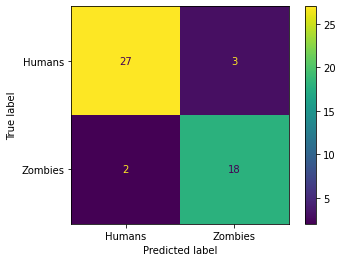

In [22]:
plot_confusion_matrix(clf_xgb,
                     X_test,
                     y_test,
                     values_format='d',
                     display_labels=['Humans', 'Zombies'])

In the confusion matrix, we see that of the **30** people that **were humans**, **27 (90%)** were correctly classified.  And of the **20** people that **were zombies**, **18 (90%)** were correctly classified.  So the **XGBoost** was pretty good, however, I would have liked alot more data to test this out on.

Since thinking someone is a human when they are acutally a zombie is worse than the other way around, I am going to do some more stuff to try and get the accruacy better.  **XGBoost** has a parameter, `scale_pos_weight`, that helps with imbalanced data.  So let's try to improve predictions using **Cross Validation** to optimize the parameters.

`scale_pos_weight` adds a penalty for incorrectly classifying the minority class.  In this case that is the people who are zombies